<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
# from torchdyn.numerics.solvers import SolverTemplate
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

### Solvers

In this case, SolverTemplate and DirectSolver are not necessarily representing a neural network, but they are using nn.Module as a base class to take advantage of the aforementioned benefits.

In [58]:
class SolverTemplate(nn.Module):
    # def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
    def __init__(self):
        super().__init__()
        # self.order = order
        # self.min_factor = torch.tensor([min_factor])
        # self.max_factor = torch.tensor([max_factor])
        # self.safety = torch.tensor([safety])
        # self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        # if self.tableau is not None:
        #     c, a, bsol, berr = self.tableau
        #     self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
        #         proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        # self.safety = self.safety.to(device)
        # self.min_factor = self.min_factor.to(device)
        # self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass


class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        # super().__init__(order=1)
        super().__init__()
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        # super().__init__(order=1)
        super().__init__()
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

In [59]:
# Define model
def f(t, x):
    θ = x[..., 0]
    ω = x[..., 1]

    dθ = ω
    dω = -torch.sin(θ)

    return torch.stack((dθ, dω), dim=-1)

In [60]:
def create_initial_cond(domain):
    x0 = (
    torch.tensor(lhs(2, 100), device='cpu') * 2 - 1
    ) * domain

    return x0

In [61]:
domain_train = 1.0
x0_train = create_initial_cond(domain_train)

In [62]:
domain_validate = 1.0
x0_validate = create_initial_cond(domain_validate)

In [63]:
def create_time_span(strat_time, end_time, step_size):
    ε = 1e-10
    t_span = torch.arange(
        strat_time, end_time + ε, step_size
    )

    return t_span

In [64]:
t_span_train = create_time_span(0.0, 0.001, 0.001)
t_span_validate = create_time_span(0.0, 4*np.pi, 0.001)

In [65]:
_, x_train = odeint(f, x0_train, t_span_train, solver="rk4")
print(x_train.shape)

torch.Size([2, 100, 2])


In [80]:
_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")
print(x_validate.shape)

tensor([[[-0.8660, -0.2848],
         [-0.2147, -0.9532],
         [-0.1630,  0.4404],
         ...,
         [ 0.9528, -0.4969],
         [-0.9934,  0.9828],
         [ 0.8635, -0.7939]],

        [[-0.8663, -0.2840],
         [-0.2157, -0.9530],
         [-0.1625,  0.4405],
         ...,
         [ 0.9523, -0.4977],
         [-0.9924,  0.9837],
         [ 0.8627, -0.7947]],

        [[-0.8665, -0.2833],
         [-0.2166, -0.9527],
         [-0.1621,  0.4407],
         ...,
         [ 0.9518, -0.4985],
         [-0.9914,  0.9845],
         [ 0.8619, -0.7954]],

        ...,

        [[-0.4980, -0.7365],
         [ 0.5932, -0.7828],
         [-0.2396,  0.4041],
         ...,
         [ 1.0098,  0.3901],
         [-0.9765, -0.9970],
         [ 1.1505,  0.3831]],

        [[-0.4987, -0.7360],
         [ 0.5924, -0.7833],
         [-0.2392,  0.4043],
         ...,
         [ 1.0102,  0.3892],
         [-0.9775, -0.9962],
         [ 1.1509,  0.3822]],

        [[-0.4994, -0.7355],
       

In [67]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [68]:
net = fnn_model(2,2,32,8)

In [69]:
optimizer = Adam(net.parameters())

In [70]:
solver = ResnetSolver()
losses = []

In [71]:
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=solver
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} ")


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 | Training loss: 0.5575315435229424 


  3%|▎         | 67/2000 [00:00<00:17, 113.65it/s]

Epoch: 50 | Training loss: 0.0004561943032210943 


  6%|▋         | 130/2000 [00:01<00:12, 147.15it/s]

Epoch: 100 | Training loss: 8.981633720550509e-06 


  9%|▉         | 180/2000 [00:01<00:11, 152.16it/s]

Epoch: 150 | Training loss: 5.189333500331663e-07 


 12%|█▏        | 240/2000 [00:01<00:09, 184.11it/s]

Epoch: 200 | Training loss: 3.6673592283162557e-07 


 15%|█▍        | 296/2000 [00:01<00:07, 229.37it/s]

Epoch: 250 | Training loss: 2.6457496599962297e-07 
Epoch: 300 | Training loss: 1.8771336875443895e-07 


 19%|█▉        | 380/2000 [00:02<00:06, 260.18it/s]

Epoch: 350 | Training loss: 1.326795179017307e-07 
Epoch: 400 | Training loss: 9.4886965125164e-08 


 24%|██▎       | 474/2000 [00:02<00:07, 198.85it/s]

Epoch: 450 | Training loss: 6.973124714643944e-08 


 26%|██▋       | 530/2000 [00:02<00:06, 233.40it/s]

Epoch: 500 | Training loss: 5.327616795202027e-08 
Epoch: 550 | Training loss: 4.249872495107629e-08 


 32%|███▏      | 638/2000 [00:03<00:05, 257.33it/s]

Epoch: 600 | Training loss: 3.5263996231018697e-08 
Epoch: 650 | Training loss: 3.0167608062281264e-08 


 37%|███▋      | 745/2000 [00:03<00:04, 260.17it/s]

Epoch: 700 | Training loss: 2.6341488373412778e-08 
Epoch: 750 | Training loss: 2.3277632090149786e-08 


 43%|████▎     | 859/2000 [00:04<00:04, 275.82it/s]

Epoch: 800 | Training loss: 2.0692263461631655e-08 
Epoch: 850 | Training loss: 1.8432359369901132e-08 


 47%|████▋     | 931/2000 [00:04<00:05, 183.47it/s]

Epoch: 900 | Training loss: 1.6416796927987915e-08 


 49%|████▊     | 971/2000 [00:04<00:06, 162.86it/s]

Epoch: 950 | Training loss: 1.4601945108248354e-08 


 51%|█████     | 1019/2000 [00:05<00:07, 130.97it/s]

Epoch: 1000 | Training loss: 1.2962787035598024e-08 


 53%|█████▎    | 1065/2000 [00:05<00:07, 131.78it/s]

Epoch: 1050 | Training loss: 1.1483123354842267e-08 


 56%|█████▋    | 1129/2000 [00:06<00:06, 141.17it/s]

Epoch: 1100 | Training loss: 1.0150736826280621e-08 


 58%|█████▊    | 1159/2000 [00:06<00:06, 129.22it/s]

Epoch: 1150 | Training loss: 8.955120850538654e-09 


 61%|██████▏   | 1228/2000 [00:07<00:06, 125.70it/s]

Epoch: 1200 | Training loss: 7.886475604974474e-09 


 63%|██████▎   | 1266/2000 [00:07<00:07, 102.92it/s]

Epoch: 1250 | Training loss: 6.935309586507745e-09 


 66%|██████▌   | 1324/2000 [00:08<00:06, 109.51it/s]

Epoch: 1300 | Training loss: 6.092321592875645e-09 


 69%|██████▊   | 1374/2000 [00:08<00:05, 113.52it/s]

Epoch: 1350 | Training loss: 5.348407100313049e-09 


 71%|███████   | 1411/2000 [00:08<00:05, 108.32it/s]

Epoch: 1400 | Training loss: 4.694714400398046e-09 


 73%|███████▎  | 1455/2000 [00:09<00:04, 125.04it/s]

Epoch: 1450 | Training loss: 4.122714572244517e-09 


 76%|███████▌  | 1524/2000 [00:09<00:04, 115.38it/s]

Epoch: 1500 | Training loss: 3.624268055994022e-09 


 78%|███████▊  | 1561/2000 [00:10<00:03, 110.12it/s]

Epoch: 1550 | Training loss: 3.1916799613861025e-09 


 81%|████████  | 1618/2000 [00:10<00:04, 93.98it/s]

Epoch: 1600 | Training loss: 2.8177411431870334e-09 


 83%|████████▎ | 1657/2000 [00:11<00:03, 94.48it/s] 

Epoch: 1650 | Training loss: 2.4957546983661897e-09 


 86%|████████▌ | 1711/2000 [00:11<00:02, 98.05it/s] 

Epoch: 1700 | Training loss: 2.219548923112191e-09 


 89%|████████▉ | 1776/2000 [00:12<00:01, 119.55it/s]

Epoch: 1750 | Training loss: 1.9834784419346348e-09 


 91%|█████████ | 1819/2000 [00:12<00:01, 131.31it/s]

Epoch: 1800 | Training loss: 1.782415478957349e-09 


 94%|█████████▍| 1882/2000 [00:13<00:00, 139.93it/s]

Epoch: 1850 | Training loss: 1.611733257958873e-09 


 96%|█████████▋| 1926/2000 [00:13<00:00, 128.09it/s]

Epoch: 1900 | Training loss: 1.467283396920563e-09 


 98%|█████████▊| 1968/2000 [00:13<00:00, 129.32it/s]

Epoch: 1950 | Training loss: 1.3453689707906e-09 


100%|██████████| 2000/2000 [00:14<00:00, 140.88it/s]


### Validation

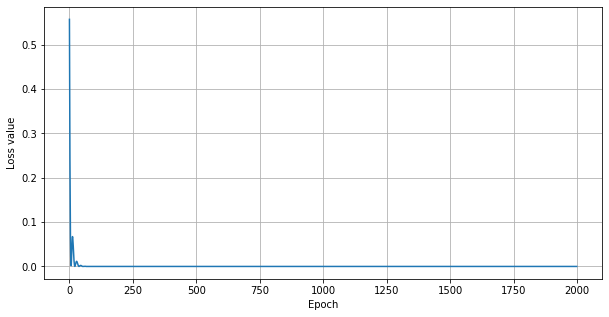

In [72]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [86]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=ResnetSolver()
    ) 

In [87]:
print(x_pred_validate.shape)
print(x_validate.shape)

torch.Size([12567, 100, 2])
torch.Size([12567, 100, 2])


In [88]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.0849, dtype=torch.float64)

In [89]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [90]:
def plot_predictions(n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    plt.subplot(121)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    plt.subplot(122)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)


    plt.subplot(121)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time ", size = 20)
    plt.ylabel(" $\theta$ (g/L)", size = 20)
    plt.legend(fontsize = 20)


    plt.subplot(122)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time", size = 20)
    plt.ylabel("$\omega$", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    plt.show()

Validation 0


<ipython-input-90-fd0d80eb5c87>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-90-fd0d80eb5c87>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


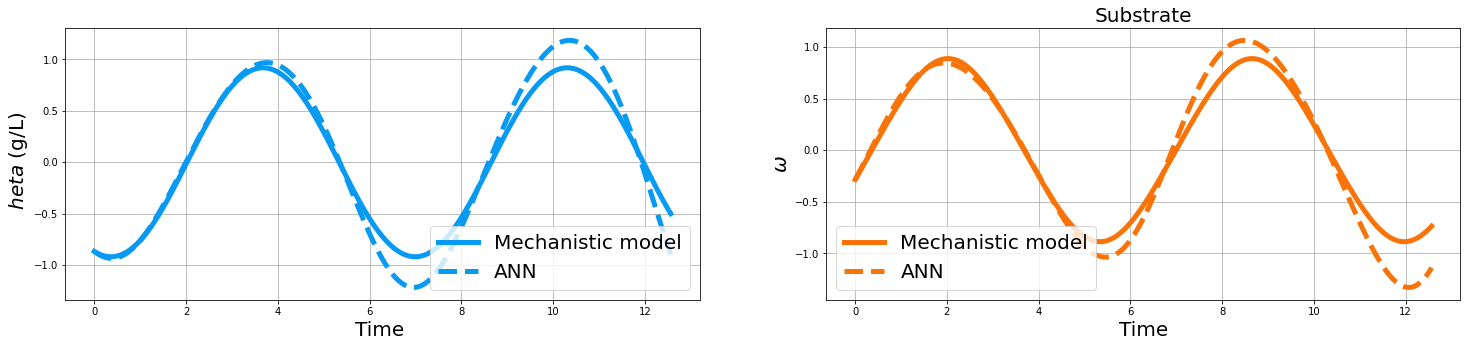

Validation 1


<ipython-input-90-fd0d80eb5c87>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-90-fd0d80eb5c87>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


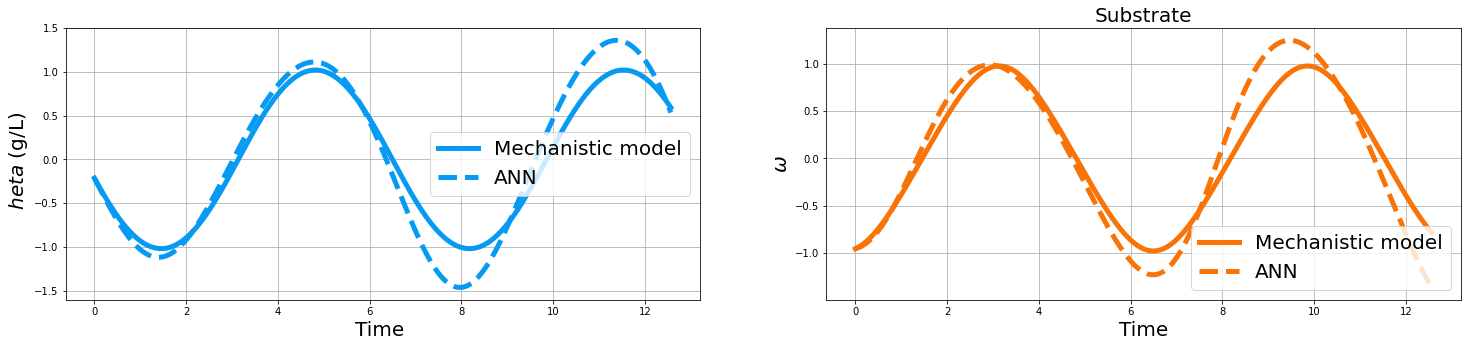

Validation 2


<ipython-input-90-fd0d80eb5c87>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-90-fd0d80eb5c87>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


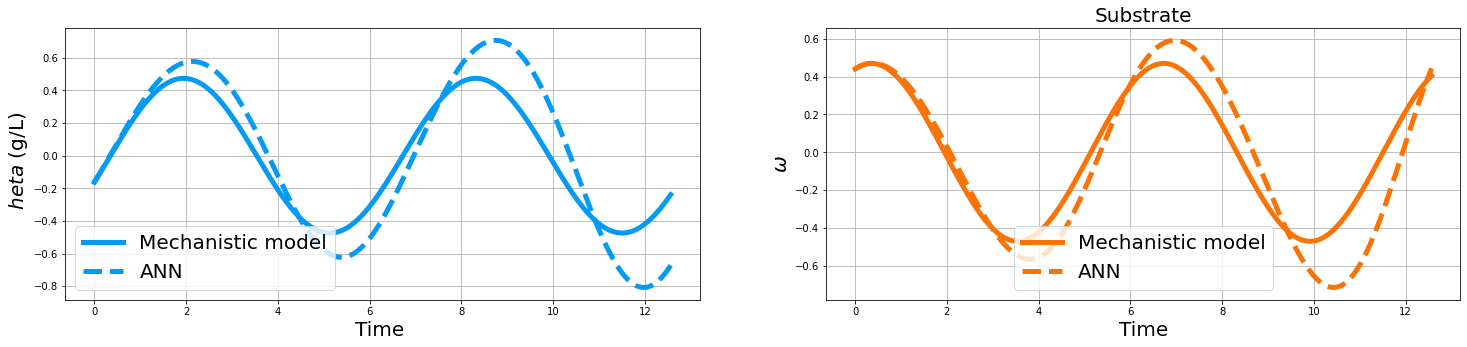

Validation 3


<ipython-input-90-fd0d80eb5c87>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-90-fd0d80eb5c87>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


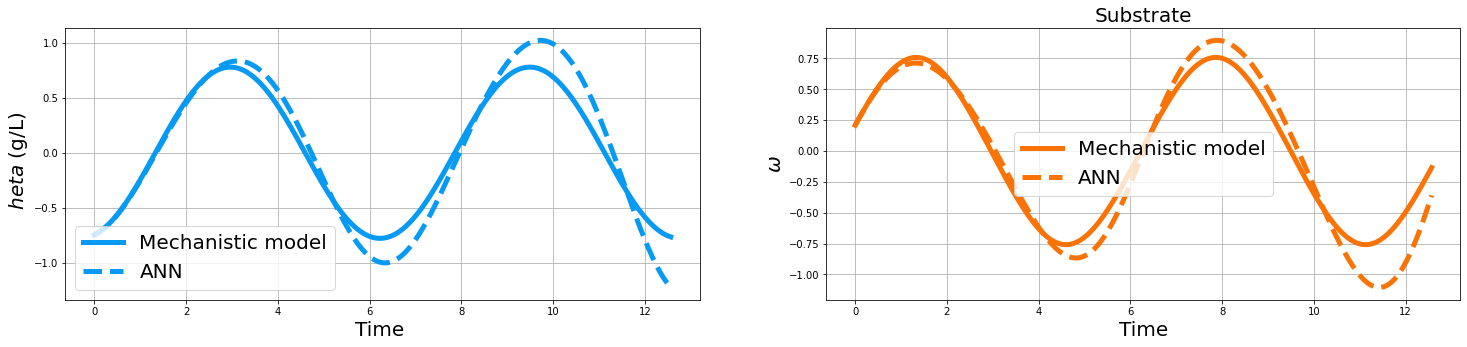

Validation 4


<ipython-input-90-fd0d80eb5c87>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-90-fd0d80eb5c87>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


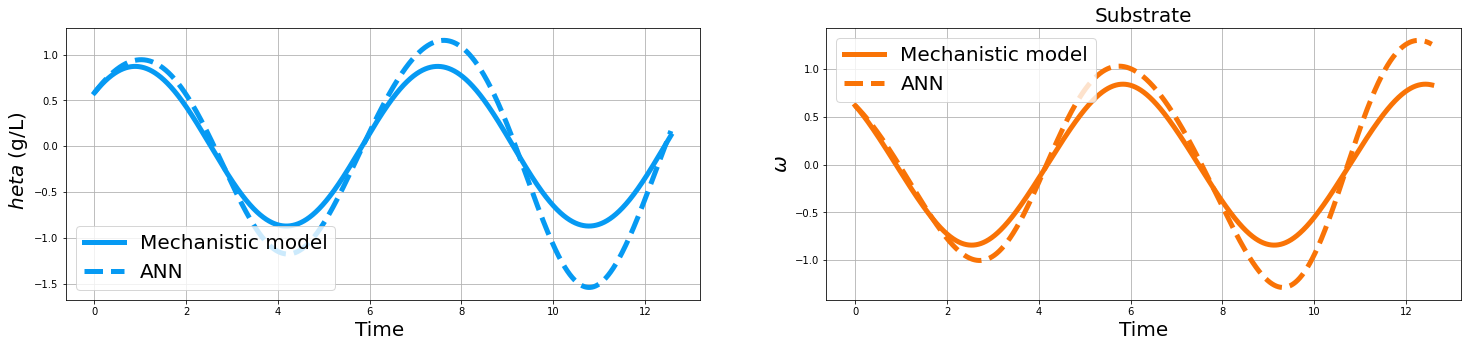

In [91]:
for i in range(5):
    plot_predictions(i)